# Data Collection Phase

In this phase , data is collected from various social media sites like Twitter and Reddit.

## 1. Collecting Data from Twitter using tweepy API

In [ ]:
import tweepy
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
#create a twitter_credentials.py file in same directory and add the following info in it.
"""
# Variables that contains the user credentials to access Twitter API 
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
"""
import twitter_credentials
import numpy as np
import pandas as pd
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets


# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)


# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)


class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

        #df['id'] = np.array([tweet.id for tweet in tweets])
        #df['len'] = np.array([len(tweet.text) for tweet in tweets])
        #df['date'] = np.array([tweet.created_at for tweet in tweets])
        #df['source'] = np.array([tweet.source for tweet in tweets])
        #df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        #df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    #tweets = api.user_timeline(screen_name="AUSvIND", count=500)
    input_string = input("Enter hashtags separated by space ")
    usertags = input_string.split()
    search_words = usertags

    date_since = "2020-01-01"

    tweets = tweepy.Cursor(api.search, search_words,
                       geocode="20.5937,78.9629,3000km",
                       lang="en", since=date_since).items(100)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    
    print(df.head(100))
    #df.to_pickle('tweets.pkl')
    df.to_csv('twitterdata.csv')
# #INDvsAUS #indvsaus

## 2. Collecting data from Reddit using Praw API

In [2]:
import praw
import pandas as pd
from praw.models import MoreComments
#create a reddit_credentials.py file in same directory and add the following info in it.
"""
reddit = praw.Reddit(client_id='',
                     client_secret='', user_agent='')
"""
import reddit_credentials

"""
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('Cricket').hot(limit=10)
for post in hot_posts:
    print(post.title)
"""
comments = []
#comments=""
threadid = input("Enter Reddit Thread id:")
submission = reddit.submission(id=threadid)
submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    #comments = comments + top_level_comment.body
    comments.append([top_level_comment.body])
    
comments = pd.DataFrame(comments,columns=['comment'])
print(comments)
#comments.to_pickle('redditdataset.pkl')
comments.to_csv('redditdataset.csv', sep='.', encoding='utf-8', index=False)
#f1zmjl

Enter Reddit Thread id:f1zmjl
                                               comment
0    So this is the worst series of Kohli like in y...
1                            Saini ODI average at 53 😂
2    SANTNER OVERRATED\n\nNEESHAM OUTDATED\n\nLONG ...
3    Kohli running with Shaw is going to be interes...
4                                            [deleted]
..                                                 ...
437             Guptill's playing on a different pitch
438  Guppy got all of his misses out of the way dur...
439     guptill is getting the orange cap at the t20wc
440  Remember when Munro was our opener? Mad times ...
441                Ok. Who brought the nanobots to NZ?

[442 rows x 1 columns]


# Data Processing Phase

Performing data mining algorithms on collected data to retrieve information.



## Applying TF-IDF to collected dataset

In [3]:
with open('twitterdata.csv', 'r') as twitterfile:
    twittertext = twitterfile.readlines()
# Converting List to String
twitterdata = ' '.join(map(str, twittertext))
#print(twitterdata)

In [4]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
ttokenized_text=sent_tokenize(twitterdata)
ttokenized_word=word_tokenize(twitterdata)

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
twitterfilter = []
for w in ttokenized_word:
    if w not in stop_words:
        twitterfilter.append(w)
td = ' '.join(map(str, twitterfilter))

In [7]:
import re
two = re.findall(r'\w+', td)
tdi = [i for i in two if not i.isdigit()]
tw = [i for i in tdi if len(i) > 3]
twitterdoc = ' '.join(map(str, tw))

In [8]:
with open('redditdataset.csv', 'r') as redditfile:
    reddittext = redditfile.readlines()
# Converting List to String
redditdata = ' '.join(map(str, reddittext))

In [9]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
tokenized_text=sent_tokenize(redditdata)
tokenized_word=word_tokenize(redditdata)

In [10]:
redditfilter = []
for w in tokenized_word:
    if w not in stop_words:
        redditfilter.append(w)
rd = ' '.join(map(str, redditfilter))

In [11]:
import re
rwo = re.findall(r'\w+', rd)
rdi = [i for i in rwo if not i.isdigit()]
fw = [i for i in rdi if len(i) > 3]
redditdoc = ' '.join(map(str, fw))

In [12]:
str_one, str_two = redditdoc[:len(redditdoc)//2],redditdoc[len(redditdoc)//2:] 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [14]:
response = tfidf.fit_transform([str_one, str_two])

In [15]:
tfidfwords = []
feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    if not feature_names[col].isdigit() and len(feature_names[col]) > 3 and int((response[0, col]) * 100) % 10 != 0:
        print (feature_names[col], ' - ', response[0, col])
        case = {'word': feature_names[col], 'score': response[0, col] }
        tfidfwords.append(case)        

definitely  -  0.014022454952636898
origin  -  0.014022454952636898
punjabi  -  0.04206736485791069
khrriya  -  0.014022454952636898
kidhar  -  0.014022454952636898
retire  -  0.014022454952636898
grandpa  -  0.014022454952636898
afghanistan  -  0.014022454952636898
teams  -  0.014022454952636898
lowest  -  0.014022454952636898
individual  -  0.014022454952636898
looked  -  0.014022454952636898
syllabus  -  0.014022454952636898
championship  -  0.014022454952636898
preparation  -  0.014022454952636898
concentration  -  0.014022454952636898
rayudu  -  0.014022454952636898
ambati  -  0.014022454952636898
scooby  -  0.014022454952636898
spanner  -  0.014022454952636898
toes  -  0.028044909905273797
powerful  -  0.014022454952636898
gaandu  -  0.014022454952636898
ground  -  0.014022454952636898
bloke  -  0.014022454952636898
stand  -  0.028044909905273797
reserve  -  0.014022454952636898
basin  -  0.014022454952636898
unamed  -  0.014022454952636898
name  -  0.028044909905273797
forget  -

patel  -  0.014022454952636898
jeetan  -  0.014022454952636898
continent  -  0.014022454952636898
spinner  -  0.028044909905273797
must  -  0.014022454952636898
kind  -  0.014022454952636898
decided  -  0.014022454952636898
bully  -  0.014022454952636898
bilateral  -  0.01995418437888069
mode  -  0.014022454952636898
madarchod  -  0.014022454952636898
streak  -  0.014022454952636898
extent  -  0.014022454952636898
done  -  0.01995418437888069
drama  -  0.014022454952636898
consistency  -  0.014022454952636898
start  -  0.01995418437888069
ends  -  0.014022454952636898
opposite  -  0.014022454952636898
bhuvi  -  0.01995418437888069
greatness  -  0.014022454952636898
important  -  0.028044909905273797
chill  -  0.014022454952636898
cricinfo  -  0.014022454952636898
robots  -  0.014022454952636898
speaking  -  0.014022454952636898
fielding  -  0.01995418437888069
commentary  -  0.03990836875776138
undeniable  -  0.014022454952636898
proof  -  0.028044909905273797
choking  -  0.01402245495

thakur  -  0.1297021984627245
shardul  -  0.03990836875776138
scoreline  -  0.014022454952636898
reflection  -  0.014022454952636898
accurate  -  0.014022454952636898
entirely  -  0.014022454952636898
pasting  -  0.014022454952636898
brutal  -  0.028044909905273797
really  -  0.029931276568321036
think  -  0.05986255313664207
side  -  0.03990836875776138
promote  -  0.014022454952636898
reckon  -  0.028044909905273797
smith  -  0.01995418437888069
steve  -  0.014022454952636898
better  -  0.03990836875776138
today  -  0.07981673751552276
five  -  0.014022454952636898
last  -  0.049885460947201726
third  -  0.014022454952636898
completes  -  0.014022454952636898
rahul  -  0.14965638284160518
soon  -  0.028044909905273797
batting  -  0.07981673751552276
jadeja  -  0.029931276568321036
whitewash  -  0.049885460947201726
dumb  -  0.014022454952636898
holeing  -  0.014022454952636898
genius  -  0.014022454952636898
looks  -  0.06983964532608242
every  -  0.06983964532608242
x200b  -  0.0140

In [16]:
#sorting the list in ascending order , taking the word value and reversing the final list
tfsorted = []
words = []
tfsorted = sorted(tfidfwords, key = lambda i: i['score']) 
#print(tfsorted)
words = [d['word'] for d in tfsorted]
words.reverse()
#making list distinct
from collections import OrderedDict
asp = list(dict.fromkeys(words))
asp = [x for x in asp if x != 'https']

In [17]:
fdt = redditdata
wlist = asp[:10]
fdt = fdt.replace("Bumrah", "bumrah")

In [18]:
fre = []
for i in wlist:
    dl = []
    for sentence in fdt.split('.'):
        if i in sentence:
                dl.append(sentence + '.')
    fre.append(dl)

In [19]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from ipywidgets import Layout

In [22]:
def buttondisp():
    backbtn.layout.visibility = 'visible'
    tw1.layout.display = 'none'
    tw2.layout.display = 'none'
    tw3.layout.display = 'none'
    tw4.layout.display = 'none'
    tw5.layout.display = 'none'
    tw6.layout.display = 'none'
    tw7.layout.display = 'none'
    tw8.layout.display = 'none'
    tw9.layout.display = 'none'
    tw10.layout.display = 'none'
    

backbtn = widgets.Button(
description="Back",
disabled=False,
icon=''
)

backbtnout = widgets.Output()
def backbtnclicked(_):
    with backbtnout:
        clear_output()
        buttondisp()

        
            
backbtn.on_click(backbtnclicked)


tw1 = widgets.Button(
description=asp[0],
disabled=False,
icon=''
)

tw1out = widgets.Output()
def tw1clicked(_):
    with tw1out:
        clear_output()
        rd = ' '.join(map(str, fre[0][:5]))
        buttondisp()
        print("Top comments about :",asp[0],"\n")
        print(rd)
            
tw1.on_click(tw1clicked)


tw2 = widgets.Button(
description=asp[1],
disabled=False,
icon=''
)

tw2out = widgets.Output()
def tw2clicked(_):
    with tw2out:
        clear_output()
        rd = ' '.join(map(str, fre[1][:5]))
        buttondisp()
        print("Top comments about :",asp[1],"\n")
        print(rd)
            
tw2.on_click(tw2clicked)


tw3 = widgets.Button(
description=asp[2],
disabled=False,
icon=''
)

tw3out = widgets.Output()
def tw3clicked(_):
    with tw3out:
        clear_output()
        rd = ' '.join(map(str, fre[2][:5]))
        buttondisp()
        print("Top comments about :",asp[2],"\n")
        print(rd)
            
tw3.on_click(tw3clicked)



tw4 = widgets.Button(
description=asp[3],
disabled=False,
icon=''
)

tw4out = widgets.Output()
def tw4clicked(_):
    with tw4out:
        clear_output()
        rd = ' '.join(map(str, fre[3][:5]))
        buttondisp()
        print("Top comments about :",asp[3],"\n")
        print(rd)
            
tw4.on_click(tw4clicked)


tw5 = widgets.Button(
description=asp[4],
disabled=False,
icon=''
)

tw5out = widgets.Output()
def tw5clicked(_):
    with tw5out:
        clear_output()
        rd = ' '.join(map(str, fre[4][:5]))
        buttondisp()
        print("Top comments about :",asp[4],"\n")
        print(rd)
            
tw5.on_click(tw5clicked)


tw6 = widgets.Button(
description=asp[5],
disabled=False,
icon=''
)

tw6out = widgets.Output()
def tw6clicked(_):
    with tw6out:
        clear_output()
        rd = ' '.join(map(str, fre[5][:5]))
        buttondisp()
        print("Top comments about :",asp[5],"\n")
        print(rd)
            
tw6.on_click(tw6clicked)

tw7 = widgets.Button(
description=asp[6],
disabled=False,
icon=''
)

tw7out = widgets.Output()
def tw7clicked(_):
    with tw7out:
        clear_output()
        rd = ' '.join(map(str, fre[6][:5]))
        buttondisp()
        print("Top comments about :",asp[6],"\n")
        print(rd)
            
tw7.on_click(tw7clicked)

tw8 = widgets.Button(
description=asp[7],
disabled=False,
icon=''
)

tw8out = widgets.Output()
def tw8clicked(_):
    with tw8out:
        clear_output()
        rd = ' '.join(map(str, fre[7][:5]))
        buttondisp()
        print("Top comments about :",asp[7],"\n")
        print(rd)
            
tw8.on_click(tw8clicked)


tw9 = widgets.Button(
description=asp[8],
disabled=False,
icon=''
)

tw9out = widgets.Output()
def tw9clicked(_):
    with tw9out:
        clear_output()
        rd = ' '.join(map(str, fre[8][:5]))
        buttondisp()
        print("Top comments about :",asp[8],"\n")
        print(rd)
            
tw9.on_click(tw9clicked)


tw10 = widgets.Button(
description=asp[9],
disabled=False,
icon=''
)

tw10out = widgets.Output()
def tw10clicked(_):
    with tw10out:
        clear_output()
        rd = ' '.join(map(str, fre[9][:5]))
        buttondisp()
        print("Top comments about :",asp[9],"\n")
        print(rd)
            
tw10.on_click(tw10clicked)

backbtn.layout.visibility = 'hidden'
print("Fans mostly talked about:")
vtpcomm = widgets.HBox([tw1,tw1out,tw2,tw2out,tw3,tw3out,tw4,tw4out,tw5,tw5out,tw6,tw6out,tw7,tw7out,tw8,tw8out,tw9,tw9out,tw10,tw10out,backbtn,backbtnout])
vtpcomm



Fans mostly talked about:


## Applying K-Means Clustering on Dataset

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [24]:
#combining reddit and twitter data
finaldatatext = fw

In [25]:
#making the list distinct for processing
finaldatatext = list(set(finaldatatext))
len(finaldatatext)

1651

In [26]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(finaldatatext)

In [27]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [29]:
clusterlists = []
for i in range(true_k):
    dummy_list  = []
    for ind in order_centroids[i]:
        #print( '%s' % terms[ind])
        dummy_list.append('%s' % terms[ind])
    clusterlists.append(dummy_list)

In [30]:
btkeywords = ['bat', 'batting',]
bowkeywords = ['bowling', 'spinner','spin']
fieldkeywords = ['field','catch', 'fielding', 'keeper','hand']

In [31]:
#print(clusterlists[0])

## Domain Classification of three clusters into Batting , Bowling & Fielding

In [32]:
bt = []  
bw = []  
fd = []
for i in btkeywords:
    if i in btkeywords and i in clusterlists[0]:
        bt = clusterlists[0]
    elif i in btkeywords and i in clusterlists[1]:
        bt = clusterlists[1]
    else:
        bt = clusterlists[2]
#print("Top values of batting cluster : ",bt[:10])    

In [33]:
for i in bowkeywords:
    if i in bowkeywords and i in clusterlists[1]:
        bw = clusterlists[1]
    elif i in bowkeywords and i in clusterlists[0]:
        bw = clusterlists[0]
    else:
        bw = clusterlists[2]
#print("Top values of bowling cluster : ",bw[:10])

In [34]:
for i in fieldkeywords:
    if i in fieldkeywords and i in clusterlists[2]:
        fd = clusterlists[2]
    elif i in fieldkeywords and i in clusterlists[1]:
        fd = clusterlists[1]
    else:
        fd = clusterlists[0]
#print("Top values of fielding cluster :",fd[:10])

In [35]:
#print(bw)
bt = bt[:1000]
bw = bw[:1000]
#print(bw)
fd = fd[:1000]

## Sorting original TF-IDF values into three clusters

In [36]:
#clustering tf-idf values
bttfidf = []
for i in asp:
    if i in asp and i in bt:
        bttfidf.append(i)
#print("Top TF - IDF scores on batting ",bttfidf[:10])

In [37]:
btlist = bttfidf[:10]
qw = []
for i in btlist:
    er = []
    for sentence in fdt.split('.'):
        if i in sentence:
                er.append(sentence + '.')
    qw.append(er)

In [38]:
#jk = ' '.join(map(str, qw[6][:5]))
#print(jk)

In [41]:
def buttondisp():
    bt1.layout.display = 'none'
    bt2.layout.display = 'none'
    bt3.layout.display = 'none'
    bt4.layout.display = 'none'
    bt5.layout.display = 'none'
    bt6.layout.display = 'none'
    bt7.layout.display = 'none'
    bt8.layout.display = 'none'
    bt9.layout.display = 'none'
    bt10.layout.display = 'none'
    

bt1 = widgets.Button(
description=btlist[0],
disabled=False,
icon=''
)

bt1out = widgets.Output()
def bt1clicked(_):
    with bt1out:
        clear_output()
        jk = ' '.join(map(str, qw[0][:5]))
        buttondisp()
        print("Top comments about :",btlist[0],"\n")
        print(jk)
            
bt1.on_click(bt1clicked)

bt2 = widgets.Button(
description=btlist[1],
disabled=False,
icon=''
)

bt2out = widgets.Output()
def bt2clicked(_):
    with bt2out:
        clear_output()
        jk = ' '.join(map(str, qw[1][:5]))
        buttondisp()
        print("Top comments about :",btlist[1],"\n")
        print(jk)
            
bt2.on_click(bt2clicked)


bt3 = widgets.Button(
description=btlist[2],
disabled=False,
icon=''
)

bt3out = widgets.Output()
def bt3clicked(_):
    with bt3out:
        clear_output()
        jk = ' '.join(map(str, qw[2][:5]))
        buttondisp()
        print("Top comments about :",btlist[2],"\n")
        print(jk)
            
bt3.on_click(bt3clicked)



bt4 = widgets.Button(
description=btlist[3],
disabled=False,
icon=''
)

bt4out = widgets.Output()
def bt4clicked(_):
    with bt4out:
        clear_output()
        jk = ' '.join(map(str, qw[3][:5]))
        buttondisp()
        print("Top comments about :",btlist[3],"\n")
        print(jk)
            
bt4.on_click(bt4clicked)


bt5 = widgets.Button(
description=btlist[4],
disabled=False,
icon=''
)

bt5out = widgets.Output()
def bt5clicked(_):
    with bt5out:
        clear_output()
        jk = ' '.join(map(str, qw[4][:5]))
        buttondisp()
        print("Top comments about :",btlist[4],"\n")
        print(jk)
            
bt5.on_click(bt5clicked)


bt6 = widgets.Button(
description=btlist[5],
disabled=False,
icon=''
)

bt6out = widgets.Output()
def bt6clicked(_):
    with bt6out:
        clear_output()
        jk = ' '.join(map(str, qw[5][:5]))
        buttondisp()
        print("Top comments about :",btlist[5],"\n")
        print(jk)
            
bt6.on_click(bt6clicked)

bt7 = widgets.Button(
description=btlist[6],
disabled=False,
icon=''
)

bt7out = widgets.Output()
def bt7clicked(_):
    with bt7out:
        clear_output()
        jk = ' '.join(map(str, qw[6][:5]))
        buttondisp()
        print("Top comments about :",btlist[6],"\n")
        print(jk)
            
bt7.on_click(bt7clicked)

bt8 = widgets.Button(
description=btlist[7],
disabled=False,
icon=''
)

bt8out = widgets.Output()
def bt8clicked(_):
    with bt8out:
        clear_output()
        jk = ' '.join(map(str, qw[7][:5]))
        buttondisp()
        print("Top comments about :",btlist[7],"\n")
        print(jk)
            
bt8.on_click(bt8clicked)


bt9 = widgets.Button(
description=btlist[8],
disabled=False,
icon=''
)

bt9out = widgets.Output()
def bt9clicked(_):
    with bt9out:
        clear_output()
        jk = ' '.join(map(str, qw[8][:5]))
        buttondisp()
        print("Top comments about :",btlist[8],"\n")
        print(jk)
            
bt9.on_click(bt9clicked)


bt10 = widgets.Button(
description=btlist[9],
disabled=False,
icon=''
)

bt10out = widgets.Output()
def bt10clicked(_):
    with bt10out:
        clear_output()
        jk = ' '.join(map(str, qw[9][:5]))
        buttondisp()
        print("Top comments about :",btlist[9],"\n")
        print(jk)
            
bt10.on_click(bt10clicked)


print("Top Batting related Comments:")
btcomm = widgets.HBox([bt1,bt1out,bt2,bt2out,bt3,bt3out,bt4,bt4out,bt5,bt5out,bt6,bt6out,bt7,bt7out,bt8,bt8out,bt9,bt9out,bt10,bt10out])
btcomm

Top Batting related Comments:


In [42]:
bwtfidf = []
for i in asp:
    if i in asp and i in bw:
        bwtfidf.append(i)
#print("Top TF - IDF scores on bowling ",bwtfidf[:10])

In [43]:
bwlist = bwtfidf[:10]
qw = []
for i in bwlist:
    er = []
    for sentence in fdt.split('.'):
        if i in sentence:
                er.append(sentence + '.')
    qw.append(er)

In [44]:
def buttondisp():
    bw1.layout.display = 'none'
    bw2.layout.display = 'none'
    bw3.layout.display = 'none'
    bw4.layout.display = 'none'
    bw5.layout.display = 'none'
    bw6.layout.display = 'none'
    bw7.layout.display = 'none'
    bw8.layout.display = 'none'
    bw9.layout.display = 'none'
    bw10.layout.display = 'none'
    

bw1 = widgets.Button(
description=bwlist[0],
disabled=False,
icon=''
)

bw1out = widgets.Output()
def bw1clicked(_):
    with bw1out:
        clear_output()
        jk = ' '.join(map(str, qw[0][:5]))
        buttondisp()
        print("Top comments about :",bwlist[0],"\n")
        print(jk)
            
bw1.on_click(bw1clicked)

bw2 = widgets.Button(
description=bwlist[1],
disabled=False,
icon=''
)

bw2out = widgets.Output()
def bw2clicked(_):
    with bw2out:
        clear_output()
        jk = ' '.join(map(str, qw[1][:5]))
        buttondisp()
        print("Top comments about :",bwlist[1],"\n")
        print(jk)
            
bw2.on_click(bw2clicked)


bw3 = widgets.Button(
description=bwlist[2],
disabled=False,
icon=''
)

bw3out = widgets.Output()
def bw3clicked(_):
    with bw3out:
        clear_output()
        jk = ' '.join(map(str, qw[2][:5]))
        buttondisp()
        print("Top comments about :",bwlist[2],"\n")
        print(jk)
            
bw3.on_click(bw3clicked)



bw4 = widgets.Button(
description=bwlist[3],
disabled=False,
icon=''
)

bw4out = widgets.Output()
def bw4clicked(_):
    with bw4out:
        clear_output()
        jk = ' '.join(map(str, qw[3][:5]))
        buttondisp()
        print("Top comments about :",bwlist[3],"\n")
        print(jk)
            
bw4.on_click(bw4clicked)


bw5 = widgets.Button(
description=bwlist[4],
disabled=False,
icon=''
)

bw5out = widgets.Output()
def bw5clicked(_):
    with bw5out:
        clear_output()
        jk = ' '.join(map(str, qw[4][:5]))
        buttondisp()
        print("Top comments about :",bwlist[4],"\n")
        print(jk)
            
bw5.on_click(bw5clicked)


bw6 = widgets.Button(
description=bwlist[5],
disabled=False,
icon=''
)

bw6out = widgets.Output()
def bw6clicked(_):
    with bw6out:
        clear_output()
        jk = ' '.join(map(str, qw[5][:5]))
        buttondisp()
        print("Top comments about :",bwlist[5],"\n")
        print(jk)
            
bw6.on_click(bw6clicked)

bw7 = widgets.Button(
description=bwlist[6],
disabled=False,
icon=''
)

bw7out = widgets.Output()
def bw7clicked(_):
    with bw7out:
        clear_output()
        jk = ' '.join(map(str, qw[6][:5]))
        buttondisp()
        print("Top comments about :",bwlist[6],"\n")
        print(jk)
            
bw7.on_click(bw7clicked)

bw8 = widgets.Button(
description=bwlist[7],
disabled=False,
icon=''
)

bw8out = widgets.Output()
def bw8clicked(_):
    with bw8out:
        clear_output()
        jk = ' '.join(map(str, qw[7][:5]))
        buttondisp()
        print("Top comments about :",bwlist[7],"\n")
        print(jk)
            
bw8.on_click(bw8clicked)


bw9 = widgets.Button(
description=bwlist[8],
disabled=False,
icon=''
)

bw9out = widgets.Output()
def bw9clicked(_):
    with bw9out:
        clear_output()
        jk = ' '.join(map(str, qw[8][:5]))
        buttondisp()
        print("Top comments about :",bwlist[8],"\n")
        print(jk)
            
bw9.on_click(bw9clicked)


bw10 = widgets.Button(
description=bwlist[9],
disabled=False,
icon=''
)

bw10out = widgets.Output()
def bw10clicked(_):
    with bw10out:
        clear_output()
        jk = ' '.join(map(str, qw[9][:5]))
        buttondisp()
        print("Top comments about :",bwlist[9],"\n")
        print(jk)
            
bw10.on_click(bw10clicked)


print("Top Bowling related Comments:")
bwcomm = widgets.HBox([bw1,bw1out,bw2,bw2out,bw3,bw3out,bw4,bw4out,bw5,bw5out,bw6,bw6out,bw7,bw7out,bw8,bw8out,bw9,bw9out,bw10,bw10out])
bwcomm

Top Bowling related Comments:


In [45]:
fdtfidf = []
for i in asp:
    if i in asp and i in fd:
        fdtfidf.append(i)
#print("Top TF - IDF scores on fielding ",fdtfidf[:10])

In [46]:
fdlist = fdtfidf[:10]
qw = []
for i in fdlist:
    er = []
    for sentence in fdt.split('.'):
        if i in sentence:
                er.append(sentence + '.')
    qw.append(er)

In [47]:
def buttondisp():
    fd1.layout.display = 'none'
    fd2.layout.display = 'none'
    fd3.layout.display = 'none'
    fd4.layout.display = 'none'
    fd5.layout.display = 'none'
    fd6.layout.display = 'none'
    fd7.layout.display = 'none'
    fd8.layout.display = 'none'
    fd9.layout.display = 'none'
    fd10.layout.display = 'none'
    

fd1 = widgets.Button(
description=fdlist[0],
disabled=False,
icon=''
)

fd1out = widgets.Output()
def fd1clicked(_):
    with fd1out:
        clear_output()
        jk = ' '.join(map(str, qw[0][:5]))
        buttondisp()
        print("Top comments about :",fdlist[0],"\n")
        print(jk)
            
fd1.on_click(fd1clicked)

fd2 = widgets.Button(
description=fdlist[1],
disabled=False,
icon=''
)

fd2out = widgets.Output()
def fd2clicked(_):
    with fd2out:
        clear_output()
        jk = ' '.join(map(str, qw[1][:5]))
        buttondisp()
        print("Top comments about :",fdlist[1],"\n")
        print(jk)
            
fd2.on_click(fd2clicked)


fd3 = widgets.Button(
description=fdlist[2],
disabled=False,
icon=''
)

fd3out = widgets.Output()
def fd3clicked(_):
    with fd3out:
        clear_output()
        jk = ' '.join(map(str, qw[2][:5]))
        buttondisp()
        print("Top comments about :",fdlist[2],"\n")
        print(jk)
            
fd3.on_click(fd3clicked)



fd4 = widgets.Button(
description=fdlist[3],
disabled=False,
icon=''
)

fd4out = widgets.Output()
def fd4clicked(_):
    with fd4out:
        clear_output()
        jk = ' '.join(map(str, qw[3][:5]))
        buttondisp()
        print("Top comments about :",fdlist[3],"\n")
        print(jk)
            
fd4.on_click(fd4clicked)


fd5 = widgets.Button(
description=fdlist[4],
disabled=False,
icon=''
)

fd5out = widgets.Output()
def fd5clicked(_):
    with fd5out:
        clear_output()
        jk = ' '.join(map(str, qw[4][:5]))
        buttondisp()
        print("Top comments about :",fdlist[4],"\n")
        print(jk)
            
fd5.on_click(fd5clicked)


fd6 = widgets.Button(
description=fdlist[5],
disabled=False,
icon=''
)

fd6out = widgets.Output()
def fd6clicked(_):
    with fd6out:
        clear_output()
        jk = ' '.join(map(str, qw[5][:5]))
        buttondisp()
        print("Top comments about :",fdlist[5],"\n")
        print(jk)
            
fd6.on_click(fd6clicked)

fd7 = widgets.Button(
description=fdlist[6],
disabled=False,
icon=''
)

fd7out = widgets.Output()
def fd7clicked(_):
    with fd7out:
        clear_output()
        jk = ' '.join(map(str, qw[6][:5]))
        buttondisp()
        print("Top comments about :",fdlist[6],"\n")
        print(jk)
            
fd7.on_click(fd7clicked)

fd8 = widgets.Button(
description=fdlist[7],
disabled=False,
icon=''
)

fd8out = widgets.Output()
def fd8clicked(_):
    with fd8out:
        clear_output()
        jk = ' '.join(map(str, qw[7][:5]))
        buttondisp()
        print("Top comments about :",fdlist[7],"\n")
        print(jk)
            
fd8.on_click(fd8clicked)


fd9 = widgets.Button(
description=fdlist[8],
disabled=False,
icon=''
)

fd9out = widgets.Output()
def fd9clicked(_):
    with fd9out:
        clear_output()
        jk = ' '.join(map(str, qw[8][:5]))
        buttondisp()
        print("Top comments about :",fdlist[8],"\n")
        print(jk)
            
fd9.on_click(fd9clicked)


fd10 = widgets.Button(
description=fdlist[9],
disabled=False,
icon=''
)

fd10out = widgets.Output()
def fd10clicked(_):
    with fd10out:
        clear_output()
        jk = ' '.join(map(str, qw[9][:5]))
        buttondisp()
        print("Top comments about :",fdlist[9],"\n")
        print(jk)
            
fd10.on_click(fd10clicked)


print("Top Fielding related Comments:")
vtpcomm = widgets.HBox([fd1,fd1out,fd2,fd2out,fd3,fd3out,fd4,fd4out,fd5,fd5out,fd6,fd6out,fd7,fd7out,fd8,fd8out,fd9,fd9out,fd10,fd10out])
vtpcomm

Top Fielding related Comments:


## Storing Cluster results to csv for cluster based sentiment analysis

In [48]:
btcomms = []
btdm = []
for i in bttfidf:
    for sentence in fdt.split('.'):
        if i in sentence:
                btdm.append(sentence + '.')
    btcomms.append(btdm)

dfa = pd.DataFrame(btdm)
dfa.to_csv('batting.csv', sep='.', encoding='utf-8', index=False)

In [49]:
bwcomms = []
bwdm = []
for i in bwtfidf:
    for sentence in fdt.split('.'):
        if i in sentence:
                bwdm.append(sentence + '.')
    bwcomms.append(bwdm)
dfa = pd.DataFrame(bwdm)
dfa.to_csv('bowling.csv', sep='.', encoding='utf-8', index=False)

In [50]:
fdcomms = []
fddm = []
for i in fdtfidf:
    for sentence in fdt.split('.'):
        if i in sentence:
                fddm.append(sentence + '.')
    fdcomms.append(fddm)
dfa = pd.DataFrame(fddm)
dfa.to_csv('fielding.csv', sep='.', encoding='utf-8', index=False)

# Sentiment Analysis using NLTK

In [51]:
import pandas as pd
messages = [line.rstrip() for line in open("redditdataset.csv")]
with open('batting.csv', 'r') as bt:
    batting = bt.readlines()
with open('bowling.csv', 'r') as bt:
    bowling = bt.readlines()
with open('fielding.csv', 'r') as bt:
    fielding = bt.readlines()

In [52]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [54]:
sid = SentimentIntensityAnalyzer()

In [55]:
summary = {"positive":0,"neutral":0,"negative":0}
for x in messages: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 194, 'neutral': 455, 'negative': 133}


In [56]:
bat = {"positive":0,"neutral":0,"negative":0}
for x in batting: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        bat["neutral"] +=1
    elif ss["compound"] > 0.0:
        bat["positive"] +=1
    else:
        bat["negative"] +=1
print(bat)

{'positive': 1277, 'neutral': 4171, 'negative': 878}


In [57]:
bow = {"positive":0,"neutral":0,"negative":0}
for x in bowling: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        bow["neutral"] +=1
    elif ss["compound"] > 0.0:
        bow["positive"] +=1
    else:
        bow["negative"] +=1
print(bow)

{'positive': 1171, 'neutral': 3921, 'negative': 831}


In [58]:
fid = {"positive":0,"neutral":0,"negative":0}
for x in fielding: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        fid["neutral"] +=1
    elif ss["compound"] > 0.0:
        fid["positive"] +=1
    else:
        fid["negative"] +=1
print(fid)

{'positive': 1170, 'neutral': 3920, 'negative': 830}


In [59]:
#type(summary)

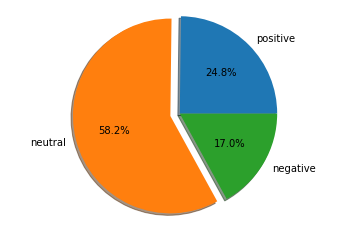

General Sentiment Analysis of Total Comments


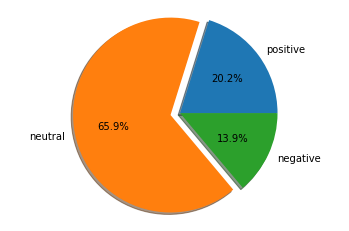

General Sentiment Analysis of Batting Cluster Comments


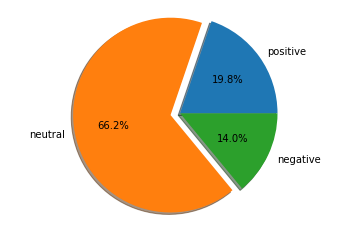

General Sentiment Analysis of Bowling Cluster Comments


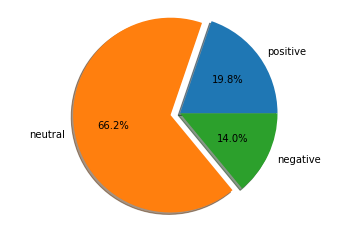

General Sentiment Analysis of Fielding Cluster Comments


In [61]:
import matplotlib.pyplot as plt
labels = tuple(summary.keys())
sizes = list(summary.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()
print("General Sentiment Analysis of Total Comments")

labels = tuple(bat.keys())
sizes = list(bat.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()
print("General Sentiment Analysis of Batting Cluster Comments")

labels = tuple(bow.keys())
sizes = list(bow.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()
print("General Sentiment Analysis of Bowling Cluster Comments")

labels = tuple(fid.keys())
sizes = list(fid.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()
print("General Sentiment Analysis of Fielding Cluster Comments")